In [1]:
import copy
import re
from dataclasses import dataclass
from functools import lru_cache
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.accept import HillClimbing
from alns.select import SegmentedRouletteWheel
from alns.stop import MaxIterations

In [2]:
%matplotlib inline

In [3]:
SEED = 5432

# The resource-constrained project scheduling problem

The following explanation is largely based on [this paper](https://pms2020.sciencesconf.org/300164/document).

The goal of the RCPSP is to schedule a set of project activities $V = \{ 0, 1, 2, \ldots, n \}$, such that the makespan of the project is minimised.
Each activity $i \in V$ has a duration $d_i \in \mathbb{N}$.
Precedence constraints impose that an activity $i \in V$ can only start after all its predecessor activities have been completed.
The precedence constraints are given by a set of edges $E \subset V \times V$, where $(i, j) \in E$ means that $i$ must be completed before $j$ can commence.
Resource constraints, on the other hand, impose that an activity can only be scheduled if sufficient resources are available.
There are $K = \{ 1, 2, \ldots, m \}$ renewable resources available, with $R_k$ indicating the availability of resource $k$.
Each activity $i \in V$ requires $r_{ik}$ units of resource $k$.
A solution to the RCPSP is a schedule of activities $S = \{ S_0, S_1, \ldots, S_n \}$, where $S_i$ is the starting time of activity $i$.
The project starts at time $S_0 = 0$, and completes at $S_n$, where activities $0$ and $n$ are dummy activities that represent the start and completion of the project, respectively.

In this notebook, we solve an instance of the RCPSP using ALNS.
In particular, we solve instance `j9041_6` of the [PSPLib](http://www.om-db.wi.tum.de/psplib/library.html) benchmark suite.
This instance consists of 90 jobs, and four resources.
The optimal makespan of this instance is known to be between 123 and 135.
We find a solution with a makespan of 141, just 4% above the best known solution to this instance.


## Data instance

In [4]:
@dataclass(frozen=True)
class ProblemData:
    num_jobs: int
    num_resources: int

    duration: np.ndarray  # job durations
    successors: List[List[int]]  # job successors
    predecessors: List[List[int]]  # job predecessors
    needs: np.ndarray  # job resource needs
    resources: np.ndarray  # resource capacities

    def __hash__(self) -> int:
        return id(self)

    @property
    def first_job(self) -> int:
        return 0

    @property
    def last_job(self) -> int:
        return self.num_jobs - 1

    @property
    @lru_cache(1)
    def all_predecessors(self) -> List[List[int]]:
        pred = [set() for _ in range(self.num_jobs)]

        for job, pre in enumerate(self.predecessors):
            for p in pre:
                pred[job] |= pred[p] | {p}

        return [sorted(p) for p in pred]

    @property
    @lru_cache(1)
    def all_successors(self) -> List[List[int]]:
        succ = [set() for _ in range(self.num_jobs)]

        for job, suc in zip(reversed(range(self.num_jobs)),
                            reversed(self.successors)):
            for s in suc:
                succ[job] |= succ[s] | {s}

        return [sorted(s) for s in succ]

    @classmethod
    def read_instance(cls, path: str) -> "ProblemData":
        """
        Reads an instance of the RCPSP from a file.
        Assumes the data is in the PSPLib format.

        Loosely based on:
        https://github.com/baobabsoluciones/hackathonbaobab2020.
        """
        with open(path) as fh:
            lines = fh.readlines()

        prec_idx = lines.index("PRECEDENCE RELATIONS:\n")
        req_idx = lines.index("REQUESTS/DURATIONS:\n")
        avail_idx = lines.index("RESOURCEAVAILABILITIES:\n")

        successors = []

        for line in lines[prec_idx + 2: req_idx - 1]:
            _, _, modes, num_succ, *jobs, _ = re.split("\s+", line)
            successors.append(list(map(lambda x: int(x) - 1, jobs)))

        predecessors = [[] for _ in range(len(successors))]

        for job in range(len(successors)):
            for succ in successors[job]:
                predecessors[succ].append(job)

        needs = []
        durations = []

        for line in lines[req_idx + 3: avail_idx - 1]:
            _, _, _, duration, *consumption, _ = re.split("\s+", line)

            needs.append(list(map(int, consumption)))
            durations.append(int(duration))

        _, *avail, _ = re.split("\s+", lines[avail_idx + 2])
        resources = list(map(int, avail))

        return ProblemData(len(durations),
                           len(resources),
                           np.array(durations),
                           successors,
                           predecessors,
                           np.array(needs),
                           np.array(resources))

In [5]:
instance = ProblemData.read_instance('j9041_6.sm')

In [6]:
DELTA = 0.75  # resource utilisation threshold
ITERS = 5_000

START_TRESH = 5  # start threshold for RRT
STEP = 20 / ITERS  # step size for RRT

THETA = 0.9  # weight decay parameter
WEIGHTS = [25, 5, 1, 0]  # weight scheme weights
SEG_LENGTH = 100  # weight scheme segment length

Q = int(0.2 * instance.num_jobs)

LB = 123  # lower bound on optimal makespan
UB = 135  # upper bound on optimal makespan

## Solution state

In [7]:
@lru_cache(32)
def schedule(jobs: Tuple[int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes a serial schedule of the given list of jobs. See Figure 1
    in Fleszar and Hindi (2004) for the algorithm. Returns the schedule,
    and the resources used.

    Fleszar, K. and K.S. Hindi. 2004. Solving the resource-constrained
    project scheduling problem by a variable neighbourhood search.
    _European Journal of Operational Research_. 155 (2): 402 -- 413.
    """
    used = np.zeros((instance.duration.sum(), instance.num_resources))
    sched = np.zeros(instance.num_jobs, dtype=int)

    for job in jobs:
        pred = instance.predecessors[job]
        t = max(sched[pred] + instance.duration[pred], default=0)

        needs = instance.needs[job]
        duration = instance.duration[job]

        # This efficiently determines the first feasible insertion point
        # after t. We compute whether resources are available, and add the
        # offset s of the first time sufficient are available for the
        # duration of the job.
        res_ok = np.all(used[t:] + needs <= instance.resources, axis=1)
        for s in np.flatnonzero(res_ok):
            if np.all(res_ok[s:s + duration]):
                sched[job] = t + s
                used[t + s:t + s + duration] += needs
                break

    return sched, used[:sched[instance.last_job]]

In [8]:
@dataclass
class RcpspState(State):
    """
    Solution state for the resource-constrained project scheduling problem.

    We use a list representation of the scheduled jobs, where job i is
    scheduled before j if i precedes j (i.e., the jobs are sorted
    topologically).
    """
    jobs: List[int]

    def __copy__(self):
        return RcpspState(self.jobs.copy())

    @property
    def indices(self) -> np.ndarray:
        """
        Returns a mapping from job -> idx in the schedule. Unscheduled
        jobs have index +inf.
        """
        indices = np.full(instance.num_jobs, np.inf, dtype=int)

        for idx, job in enumerate(self.jobs):
            indices[job] = idx

        return indices

    @property
    def unscheduled(self) -> List[int]:
        """
        All jobs that are not currently scheduled, in topological order.
        """
        return sorted(set(range(instance.num_jobs)) - set(self.jobs))

    def objective(self) -> int:
        s, _ = schedule(tuple(self.jobs))
        return s[instance.last_job]

    def plot(self):
        """
        Plots the current schedule. The plot includes a Gantt chart, the
        lower and upper bounds on an optimal makespan, and bar charts for
        resource use.
        """
        fig = plt.figure(figsize=(12, 6 + instance.num_resources))

        hr = [1] * (instance.num_resources + 1)
        hr[0] = 6

        gs = plt.GridSpec(nrows=1 + instance.num_resources,
                          ncols=1,
                          height_ratios=hr)

        s, u = schedule(tuple(self.jobs))
        idcs = np.argsort(s)

        gantt = fig.add_subplot(gs[0, 0])
        gantt.axvspan(LB, UB, alpha=0.25, color='grey')
        gantt.barh(np.arange(instance.num_jobs),
                   instance.duration[idcs],
                   left=s[idcs])

        gantt.set_xlim(0, self.objective())
        gantt.set_ylim(0, instance.last_job)
        gantt.invert_yaxis()

        gantt.set_title("Gantt chart")

        for res in range(instance.num_resources):
            res_ax = fig.add_subplot(gs[res + 1, 0], sharex=gantt)
            res_ax.bar(np.arange(u.shape[0]), u[:, res], align='edge')

            res_ax.set_ylim(0, instance.resources[res])
            res_ax.set_ylabel(f"R{res + 1}")

            if res == instance.num_resources - 1:
                res_ax.set_xlabel("Time")

        plt.tight_layout()

## Destroy operators

In [9]:
def most_mobile_removal(state, rnd_state):
    """
    This operator unschedules those jobs that are most mobile, that is, those
    that can be 'moved' most within the schedule, as determined by their
    scheduled predecessors and successors. Based on Muller (2009).

    Muller, LF. 2009. An Adaptive Large Neighborhood Search Algorithm
    for the Resource-constrained Project Scheduling Problem. In _MIC
    2009: The VIII Metaheuristics International Conference_.
    """
    state = copy.copy(state)
    indices = state.indices

    # Left and right limits. These are the indices of the job's last
    # predecessor and first successor in the schedule. That indicates
    # the extent of the job's movement.
    ll = np.array([np.max(indices[instance.predecessors[job]], initial=0)
                   for job in range(instance.num_jobs)])

    rl = np.array([np.min(indices[instance.successors[job]],
                          initial=instance.num_jobs)
                   for job in range(instance.num_jobs)])

    mobility = np.maximum(rl - ll, 0)
    mobility[[instance.first_job, instance.last_job]] = 0
    p = mobility / mobility.sum()

    for job in rnd_state.choice(instance.num_jobs, Q, replace=False, p=p):
        state.jobs.remove(job)

    return state

In [10]:
def non_peak_removal(state: RcpspState, rnd_state):
    """
    Removes up to Q jobs that are scheduled in periods with limited resource
    use. Those jobs might be grouped together better when they are rescheduled.
    Based on Muller (2009).

    Muller, LF. 2009. An Adaptive Large Neighborhood Search Algorithm
    for the Resource-constrained Project Scheduling Problem. In _MIC
    2009: The VIII Metaheuristics International Conference_.
    """
    state = copy.copy(state)

    start, used = schedule(tuple(state.jobs))
    end = start + instance.duration

    # Computes a measure of resource utilisation in each period, and
    # determines periods of high resource use.
    used = used / instance.resources
    high_util = np.argwhere(np.mean(used, axis=1) > DELTA)

    # These are all non-peak jobs, that is, jobs that are completely
    # scheduled in periods of limited resource use.
    jobs = [job for job in range(instance.num_jobs)
            if np.all((high_util <= start[job]) | (high_util >= end[job]))]

    for job in rnd_state.choice(jobs, min(len(jobs), Q), replace=False):
        state.jobs.remove(job)

    return state

In [11]:
def segment_removal(state, rnd_state):
    """
    Removes a whole segment of jobs from the current solution.
    """
    state = copy.copy(state)
    offset = rnd_state.randint(1, instance.num_jobs - Q)

    del state.jobs[offset:offset + Q]

    return state

## Repair operators

We only define a single repair operator: `random_insert`.
This operator takes the unscheduled jobs, and randomly inserts them in feasible locations in the schedule.
Together with a justification technique (shown below) that further improves the resulting schedule, this results in a new, hopefully improved solution.

In [12]:
def justify(state):
    """
    Helper method that double-justifies the schedule. Based on the
    justification technique of Valls et al. (2005).

    Valls, V. Ballestín, F. and S. Quintanilla. 2005. Jusitfication and
    RCPSP: A technique that pays. _ European Journal of Operational
    Research_. 165 (2): 375 -- 386.
    """
    # We first right-justify the current schedule. That more or less means
    # that we schedule jobs from the right, such that no job can be started
    # later without increases the makespan.
    makespan = state.objective()
    used = np.zeros((makespan, instance.num_resources))
    sched = np.zeros(instance.num_jobs, dtype=int)

    for job in reversed(state.jobs):
        needs = instance.needs[job]
        duration = instance.duration[job]

        t = min(sched[instance.successors[job]], default=makespan)
        res_ok = np.all(used[:t] + needs <= instance.resources, axis=1)

        for s in reversed(np.flatnonzero(res_ok[:t - duration + 1])):
            if np.all(res_ok[s:s + duration]):
                sched[job] = s
                used[s:s + duration, :] += needs
                break

    # Right-justify the schedule, and then left-justify it again. This
    # results in a double-justified schedule that is hopefully better
    # than what we got initially.
    right_justified = np.argsort(sched)
    sched, _ = schedule(tuple(right_justified))
    left_justified = np.argsort(sched).tolist()

    return RcpspState(left_justified)

In [13]:
def random_insert(state, rnd_state):
    """
    Randomly inserts jobs into the schedule. The resulting solution state
    is guaranteed to be feasible.
    """
    indices = state.indices
    preds = instance.all_predecessors
    succs = instance.all_successors

    for job in state.unscheduled:
        # Left and right insertion limits. The job must be inserted
        # between these indices - the interval is [ll, rl).
        ll = np.max(indices[preds[job]], initial=0) + 1
        rl = np.min(indices[succs[job]], initial=len(state.jobs))

        idx = rnd_state.randint(ll, rl) if ll < rl else ll
        state.jobs.insert(idx, job)

        indices[indices >= idx] += 1
        indices[job] = idx

    return justify(state)

## Initial solution

Our solution representation is a list of jobs.
We can thus easily generate an initial solution as the list of all jobs, in the (topological) order we got them.

In [14]:
init_sol = RcpspState(list(range(instance.num_jobs)))
print(f"Initial solution has objective {init_sol.objective()}.")

Initial solution has objective 172.


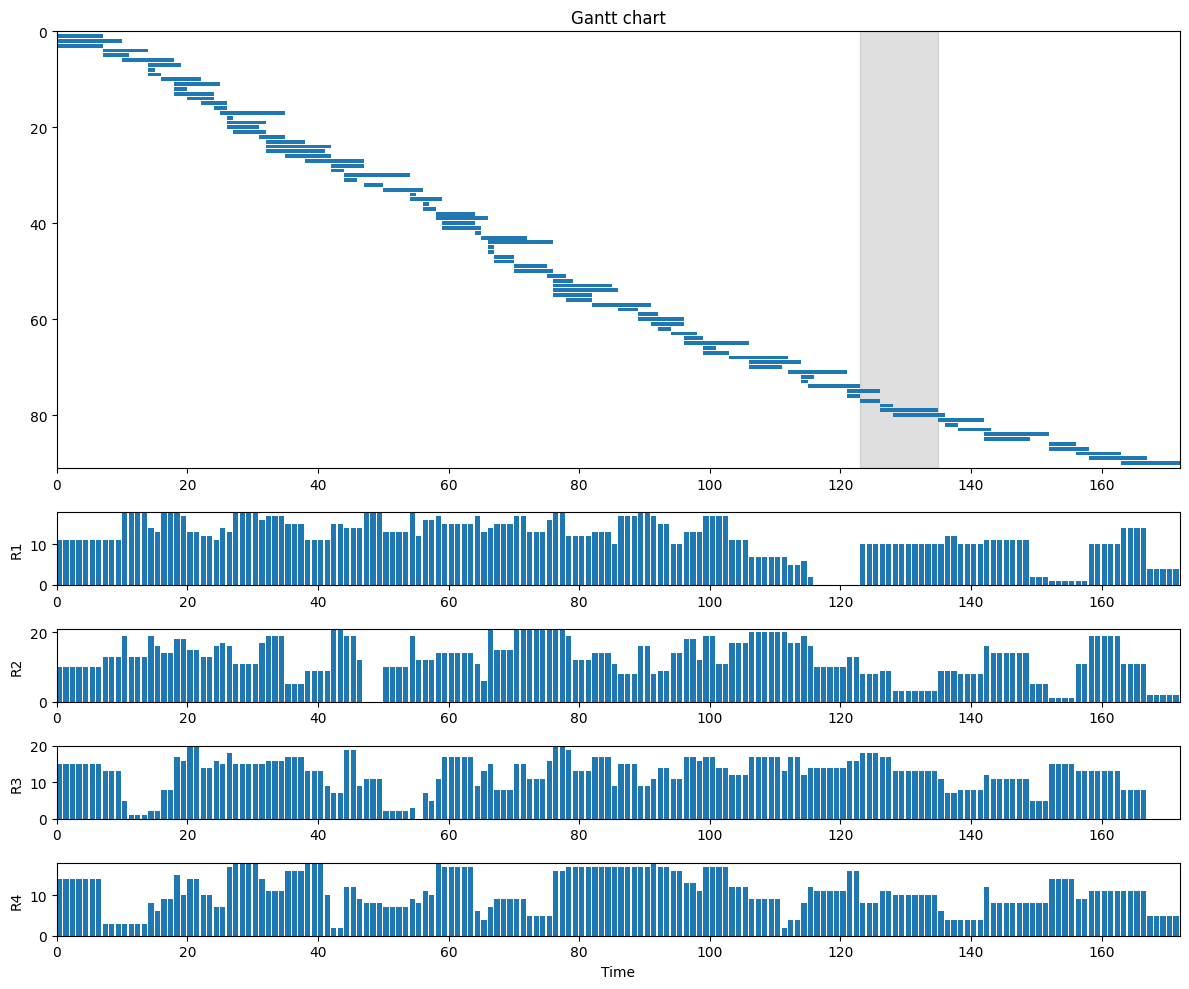

In [15]:
init_sol.plot()

## Heuristic solution

With our initial solution in hand, we can now use ALNS to further improve it.
We start consider a segmented weight strategy, and use a simple hill-climbing acceptance criterion.

In [16]:
rnd_state = rnd.RandomState(SEED)

In [17]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(most_mobile_removal)
alns.add_destroy_operator(non_peak_removal)
alns.add_destroy_operator(segment_removal)

alns.add_repair_operator(random_insert)

In [18]:
select = SegmentedRouletteWheel(WEIGHTS, THETA, SEG_LENGTH, 3, 1)
accept = HillClimbing()
stop = MaxIterations(ITERS)

res = alns.iterate(init_sol, select, accept, stop)
sol = res.best_state

print(f"Heuristic solution has objective {sol.objective()}.")

Heuristic solution has objective 141.


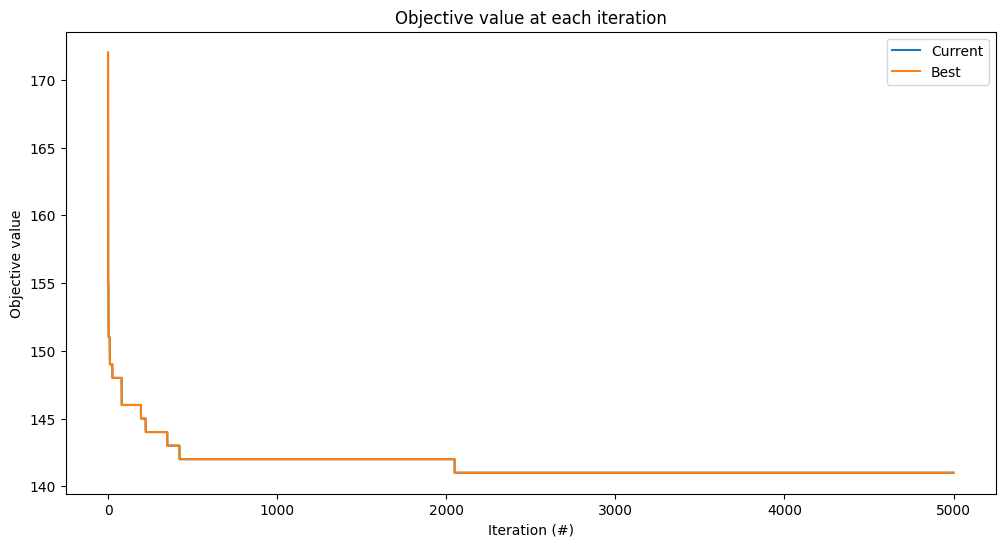

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax)

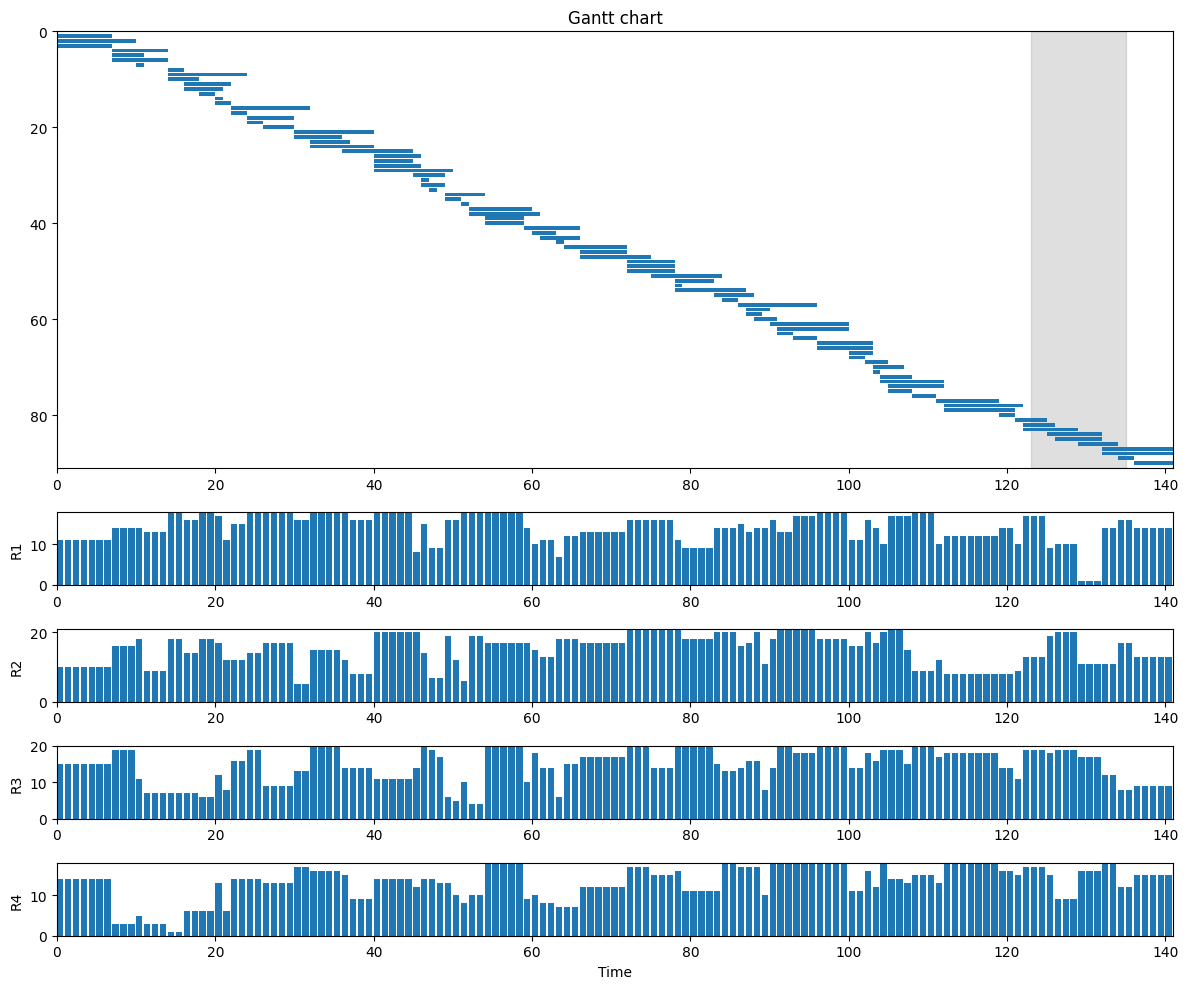

In [20]:
sol.plot()

## Conclusion

In this notebook we solved a challenging instance of the resource-constrained project scheduling problem, using several operators and enhancement techniques from the literature.
The resulting heuristic solution is competitive with other heuristics for this problem: the best known solution achieves a makespan of 135, and we find 141, just 4% higher.